## How to use the t-SNE algorithm on APOGEE globular cluster data. 
##### Steffani Grondin (September 23, 2022)

In [2]:
%pip install sklearn
%pip install shapely


Note: you may need to restart the kernel to use updated packages.


#### STEP 0: Import the necessary packages/algorithms.

In [6]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

#### STEP 1: Load in the M3 datafile. 

This example uses APOGEE DR17 data (https://www.sdss.org/dr17/) with astroNN chemical abundances (https://astronn.readthedocs.io/en/latest/) and includes all stars that are within a 10x10 degree field of view around M3's centre.

Loading in M22

In [7]:
M3 = pd.read_csv('data/M3data_10x10.csv', delimiter=',')

# Spatial:
ra = M3["ra"]   #APOGEE
dec = M3["dec"]   #APOGEE

# Identification:
apogee_ID = M3["apogee_ID"]   #APOGEE
gaia_ID = M3["gaia_ID"]  # Gaia

# Kinematic:
parallax = M3["parallax"]  # Gaia
pmra = M3["pmra"]  # Gaia
pmra_err = M3["pmra_err"]  # Gaia
pmdec = M3["pmdec"]  # Gaia
pmdec_err = M3["pmdec_err"]  # Gaia
RV = M3["RV"]   #APOGEE
RV_err = M3["RV_err"]   #APOGEE
dist = M3["dist"]   #APOGEE
dist_err = M3["dist_err"]   #APOGEE
jr = M3["jr"]   #APOGEE
jr_err = M3["jr_err"]   #APOGEE
jz = M3["jz"]   #APOGEE
jz_err = M3["jz_err"]   #APOGEE
jphi = M3["jphi"]   #APOGEE
jphi_err = M3["jphi_err"]    #APOGEE

# Spectral (useful for filtering):
TEFF_ERR = M3["TEFF_err"]   #APOGEE
TEFF = M3["TEFF"]   #APOGEE
LOGG_ERR = M3["LOGG_err"]   #APOGEE
LOGG = M3["LOGG"]   #APOGEE
SNR = M3["SNR"]   #APOGEE

# Chemical abundances from astroNN:
FE_H = M3['FEH'] 
C_FE = M3['CFE']
CI_FE = M3['CIFE']
N_FE = M3['NFE']
O_FE = M3['OFE']
MG_FE = M3['MGFE']
AL_FE = M3['ALFE']
SI_FE = M3['SIFE']
P_FE = M3['PFE']
S_FE = M3['SFE']
K_FE = M3['KFE']
CA_FE = M3['CAFE']
TI_FE = M3['TIFE']
TIII_FE = M3['TIIIFE']
V_FE = M3['VFE']
CR_FE = M3['CRFE']
MN_FE = M3['MNFE']
CO_FE = M3['COFE']
NI_FE = M3['NIFE']

# Chemical abundance errors from astroNN:
FE_H_err = M3["FEH_err"] 
C_FE_err = M3['CFE_err']
CI_FE_err = M3['CIFE_err']
N_FE_err = M3['NFE_err']
O_FE_err = M3['OFE_err']
MG_FE_err = M3['MGFE_err']
AL_FE_err = M3['ALFE_err']
SI_FE_err = M3['SIFE_err']
P_FE_err = M3['PFE_err']
S_FE_err = M3['SFE_err']
K_FE_err = M3['KFE_err']
CA_FE_err = M3['CAFE_err']
TI_FE_err = M3['TIFE_err']
TIII_FE_err = M3['TIIIFE_err']
V_FE_err = M3['VFE_err']
CR_FE_err = M3['CRFE_err']
MN_FE_err = M3['MNFE_err']
CO_FE_err = M3['COFE_err']
NI_FE_err = M3['NIFE_err']

# Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, dist, dist_err,
        jr, jr_err, jphi, jphi_err, jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, FE_H, FE_H_err, C_FE, 
        C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
        SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
        TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 5289 stars in our initial sample


In [8]:
cols[0]

0       200.548058
1       200.549980
2       200.549980
3       200.552701
4       200.554464
           ...    
5284    210.533026
5285    210.538025
5286    210.538676
5287    210.542387
5288    210.542927
Name: ra, Length: 5289, dtype: float64

#### STEP 2: Filter the data. 

First, we remove all stars without proper motions and chemical abundances for all 19 elements. Next, for stars with multiple spectra, we select the one with the highest SNR to represent the source. Finally, we remove all stars with low signal-to-noise (SNR) ratios. 

In [9]:
### Filter 1: Remove stars that do not have proper motion values. ###
pm_filter_nan = np.isnan(pmra)
pm_filter = np.where(pm_filter_nan==False)
data_pmfilter = []
for i in cols:
    x = np.array(i)[pm_filter]
    data_pmfilter.append(x)
print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))

### Filter 2: Remove stars that do not have data for all 19 abundances. ###
abundance_filter = np.where((data_pmfilter[24] > -9999) & (data_pmfilter[26] > -9999) & (data_pmfilter[28]  > -9999)
                            & (data_pmfilter[30]  > -9999) & (data_pmfilter[32]  > -9999) & (data_pmfilter[34]  > -9999)
                            & (data_pmfilter[36]  > -9999) & (data_pmfilter[38]  > -9999) & (data_pmfilter[40]  > -9999)
                            & (data_pmfilter[42]  > -9999) & (data_pmfilter[44]  > -9999) & (data_pmfilter[46]  > -9999)
                            & (data_pmfilter[48]  > -9999) & (data_pmfilter[50]  > -9999) & (data_pmfilter[52]  > -9999)
                            & (data_pmfilter[54]  > -9999) & (data_pmfilter[56]  > -9999) & (data_pmfilter[58]  > -9999)
                            & (data_pmfilter[60]  > -9999))

data_abundancefilter = []
for i in data_pmfilter:
    y = np.array(i)[abundance_filter]
    data_abundancefilter.append(y)
print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))

### Filter 3: Remove all duplicate spectra (i.e. select spectra with highest SNR for multiple measurements). ###
d =  Counter(data_abundancefilter[0])
#print(d)
duplicates = [k for k, v in d.items() if v > 1]
a_list = np.array(range(0, len(duplicates)))
max_SNR_array = []

for i in a_list:
    indices = np.where(data_abundancefilter[0] == duplicates[i])
    snr_val = data_abundancefilter[23][indices]
    maximum = max(snr_val)
    index_maximum = np.where((data_abundancefilter[0] == duplicates[i]) & (data_abundancefilter[23] == maximum))
    index_maximum = int(index_maximum[0])
    max_SNR_array.append(index_maximum)

idx_sort = np.argsort(data_abundancefilter[0])
sorted_ra_array = data_abundancefilter[0][idx_sort]
vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
res = np.split(idx_sort, idx_start[1:])
vals = vals[count == 1]
listtest =  np.array(range(0, len(vals)))

unique_array = []
for i in listtest:
    unique_val = np.where(vals[i] == data_abundancefilter[0])
    unique_val = int(unique_val[0])
    unique_array.append(unique_val)
    
print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))

duplicates_filter = np.concatenate((unique_array, max_SNR_array))
sortedarray = np.sort(duplicates_filter)

data_duplicatesfilter = []
#print(duplicates_filter)
for i in data_abundancefilter:
    z = np.array(i)[duplicates_filter]
    data_duplicatesfilter.append(z)

print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))

### Filter 4: Remove all stars with low SNR. ###
SNR_filter = np.where(data_duplicatesfilter[23] > 50)
data_snrfilter = []
for i in data_duplicatesfilter:
    a = np.array(i)[SNR_filter]
    data_snrfilter.append(a)

print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

print(data_snrfilter[3])

There are 5240 stars in our sample after the proper motion filtering.
There are 5053 stars in our sample after the abundance filtering.
There are 1918 stars that do not have duplicate spectra.
There are 1391 stars that have multiple spectra, in which we select highest SNR.
There are 3309 stars in our sample after removing sources with duplicate spectra.
There are 3212 stars in our sample after removing sources with low SNR.
[1469702181939072128 1462271785437877248 1469697337215960832 ...
 1450223749336918528 1450325591600414976 1450211379831103744]


#### ***CHECK-IN: Now that your data has been reduced, do some exploratory data analysis to see what the sample looks like!*

What parameters are in this file? What parameters might be useful to connect extra-tidal stars with a suspected birth cluster?

The data_snrfilter holds the original 62 parameters listed in the cols variable, with each subarray containing the 3212 stars that were left after the pm. abundance, duplicate, and low SNR filtering.

The useful parameters are the chemical abundances (grouping like stars), RA and DEC (locating GC control stars), and radial velocity (grouping possible kicked stars) (proper motion might also be useful?)

Text(0.5, 1.0, 'RV')

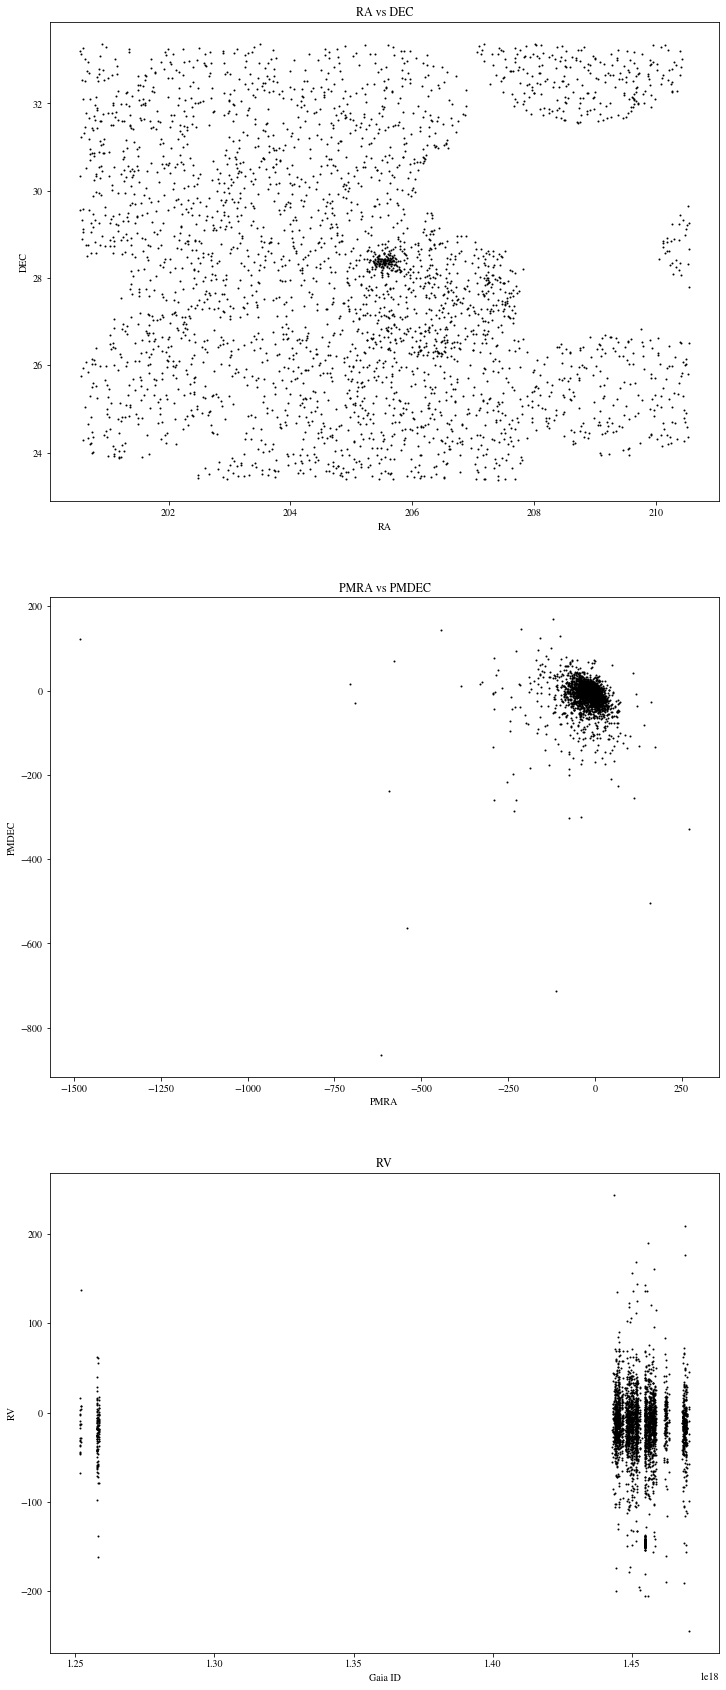

In [10]:
fig_data_anal, ax = plt.subplots(3, 1, figsize=(12,30))
ax[0].plot(data_snrfilter[0], data_snrfilter[1], color='k', markersize=1, marker='o', linestyle='none')
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].set_title('RA vs DEC')

ax[1].plot(data_snrfilter[5], data_snrfilter[7], color='k', markersize=1, marker='o', linestyle='none')
ax[1].set_xlabel('PMRA')
ax[1].set_ylabel('PMDEC')
ax[1].set_title('PMRA vs PMDEC')

ax[2].plot(data_snrfilter[3], data_snrfilter[9], color='k', markersize=1, marker='o', linestyle='none')
ax[2].set_xlabel('Gaia ID')
ax[2].set_ylabel('RV')
ax[2].set_title('RV')

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

In [11]:
ra_M3 = 205.548  # [deg]
dec_M3 = 28.3772  # [deg]
dist_M3 = 10180  # [pc]
rt_M3 = 159.0339  # [pc] -- tidal radius @ apogalacticon
rhm_M3 = 6.34  # [pc]
rhm_M3_deg = math.degrees(math.atan(rhm_M3 / dist_M3))  # deg
pmra_M3 = -0.152  # [mas/yr]
pmdec_M3 = -2.670  # [mas/yr]

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

In [12]:
# Select all the stars within some radius of the cluster:
def in_circle(center_x, center_y, radius, x, y):
    square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
    return square_dist <= (radius) ** 2

ra_filtered = data_snrfilter[0]
dec_filtered = data_snrfilter[1]

# Select stars within 8 * r,hm (useful for large enough sample of probable cluster members):
in_halfmass = in_circle(ra_M3, dec_M3, 8*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control = np.where(in_halfmass==True)

# larger rhm
in_halfmass_10 = in_circle(ra_M3, dec_M3, 10*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control_10 = np.where(in_halfmass_10==True)

# smaller rhm
in_halfmass_6 = in_circle(ra_M3, dec_M3, 6*rhm_M3_deg, ra_filtered, dec_filtered)
indices_control_6 = np.where(in_halfmass_6==True)

controlgroup = []
for i in data_snrfilter:
    b = np.array(i)[indices_control]
    controlgroup.append(b)
    
controlgroup_10 = []
for i in data_snrfilter:
    b_10 = np.array(i)[indices_control_10]
    controlgroup_10.append(b_10)
    
controlgroup_6 = []
for i in data_snrfilter:
    b_6 = np.array(i)[indices_control_6]
    controlgroup_6.append(b_6)

# Example control group parameters: 
ra_control = controlgroup[0]
dec_control = controlgroup[1]

print("There are {} stars in our M3 control group.".format(len(ra_control)))

print("There are {} stars in our M3 control group w/ size 10.".format(len(controlgroup_10[0])))

print("There are {} stars in our M3 control group w/ size 6.".format(len(controlgroup_6[0])))

There are 133 stars in our M3 control group.
There are 155 stars in our M3 control group w/ size 10.
There are 112 stars in our M3 control group w/ size 6.


#### ***CHECK-IN: Add this control group to your above exploratory plots.* 

What do you notice about these stars? What changes if you adjust the control group radius (i.e. what if you go larger or smaller than 8*r,hm)?


Smaller and larger both yield 62 for whatever reason.

Text(0.5, 1.0, 'RV')

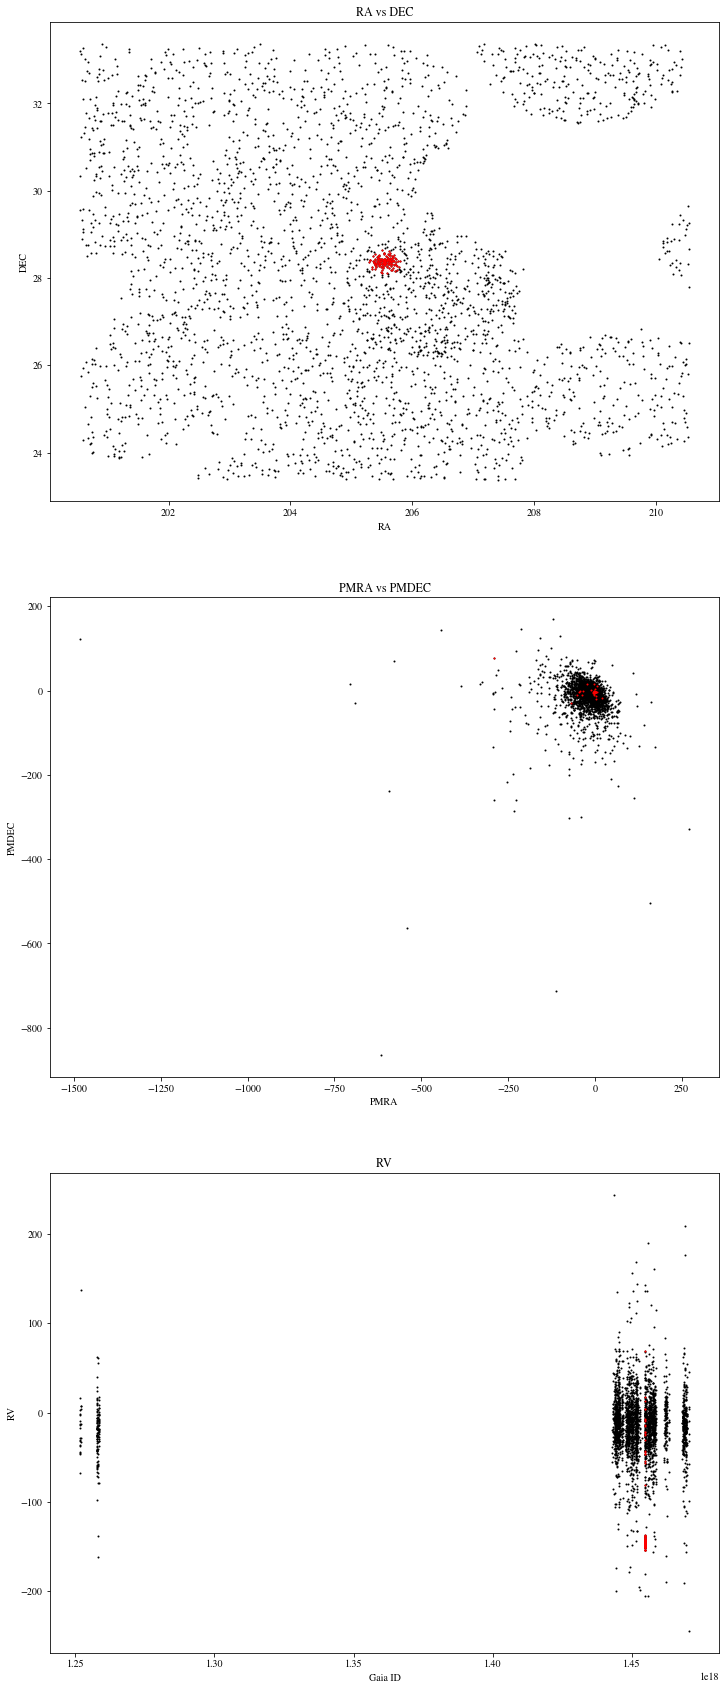

In [79]:
fig_data_anal2, ax = plt.subplots(3, 1, figsize=(12,30))
ax[0].plot(data_snrfilter[0], data_snrfilter[1], color='k', markersize=1, marker='o', linestyle='none', label='filtered star field')
ax[0].plot(controlgroup[0], controlgroup[1], color='r', markersize=1, marker='o', linestyle='none', label='M3 control group')
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].set_title('RA vs DEC')

ax[1].plot(data_snrfilter[5], data_snrfilter[7], color='k', markersize=1, marker='o', linestyle='none', label='filtered star field')
ax[1].plot(controlgroup[5], controlgroup[7], color='r', markersize=1, marker='o', linestyle='none', label='M3 control group')
ax[1].set_xlabel('PMRA')
ax[1].set_ylabel('PMDEC')
ax[1].set_title('PMRA vs PMDEC')

ax[2].plot(data_snrfilter[3], data_snrfilter[9], color='k', markersize=1, marker='o', linestyle='none', label='filtered star field')
ax[2].plot(controlgroup[3], controlgroup[9], color='r', markersize=1, marker='o', linestyle='none', label='M3 control group')
ax[2].set_xlabel('Gaia ID')
ax[2].set_ylabel('RV')
ax[2].set_title('RV')

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.  

In [80]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = data_snrfilter[24], data_snrfilter[26], data_snrfilter[28]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = data_snrfilter[30], data_snrfilter[32], data_snrfilter[34]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = data_snrfilter[36], data_snrfilter[38], data_snrfilter[40]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = data_snrfilter[42], data_snrfilter[44], data_snrfilter[46]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = data_snrfilter[48], data_snrfilter[50], data_snrfilter[52]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = data_snrfilter[54], data_snrfilter[56], data_snrfilter[58], data_snrfilter[60]
RV_filtered  = data_snrfilter[9]

pretsne_array = np.array([FE_H_filtered, C_FE_filtered, CI_FE_filtered, N_FE_filtered, O_FE_filtered, MG_FE_filtered,
                      AL_FE_filtered, SI_FE_filtered, P_FE_filtered, S_FE_filtered, K_FE_filtered, CA_FE_filtered, 
                      TI_FE_filtered, TIII_FE_filtered, V_FE_filtered, CR_FE_filtered, MN_FE_filtered, CO_FE_filtered,
                       NI_FE_filtered, RV_filtered])

standardized_array = []
for i in pretsne_array:
    mean, sigma = np.mean(i), np.std(i)
    norm = (i - mean) / sigma
    standardized_array.append(norm)

Next, we apply the t-SNE algorithm via scikit-learn to reduce the dimensionality of the data from 20-D to 2-D.

In [84]:
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
tsne_init = TSNE(n_components=2)
tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

# Get t-SNE outputs for complete filtered dataset:
t_SNE_dimX = tsne_2d[:, 0]
t_SNE_dimY = tsne_2d[:, 1]

# Get t-SNE outputs for control group:
tsne_dimX_control = t_SNE_dimX[indices_control]
tsne_dimY_control = t_SNE_dimY[indices_control]

Finally, we plot the 2-D t-SNE projection. 

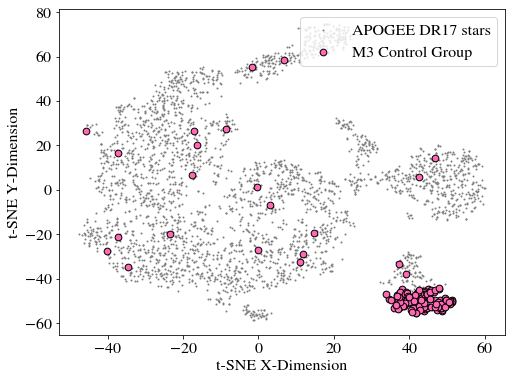

Total:  3212 Control:  133


In [85]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(t_SNE_dimX, t_SNE_dimY, s=1, c='gray', label='APOGEE DR17 stars')
ax.scatter(tsne_dimX_control , tsne_dimY_control, s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize=16, loc=1)
plt.show()
print('Total: ', len(t_SNE_dimX), 'Control: ', len(tsne_dimX_control))

#### Changing Perplexity (default 30)
related to # of nearby neighbours. Not sure what specifically

In [104]:
### Perplexity changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# perplexity list (default 30)
perp_list = [5, 10, 15, 20, 25, 35, 40, 45, 50]
t_SNE_dimX_perp = []
t_SNE_dimY_perp = []
tsne_dimX_control_perp = []
tsne_dimY_control_perp = []
for i in perp_list:
    tsne_init_perp = TSNE(n_components=2, perplexity=i)
    tsne_2d_perp = tsne_init_perp.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_perp.append(tsne_2d_perp[:, 0])
    t_SNE_dimY_perp.append(tsne_2d_perp[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_perp.append(t_SNE_dimX_perp[-1][indices_control])
    tsne_dimY_control_perp.append(t_SNE_dimY_perp[-1][indices_control])
    
    print('t_SNE done for perp =', i)

print('t_SNE done')

t_SNE done for perp = 5
t_SNE done for perp = 10
t_SNE done for perp = 15
t_SNE done for perp = 20
t_SNE done for perp = 25
t_SNE done for perp = 35
t_SNE done for perp = 40
t_SNE done for perp = 45
t_SNE done for perp = 50
t_SNE done


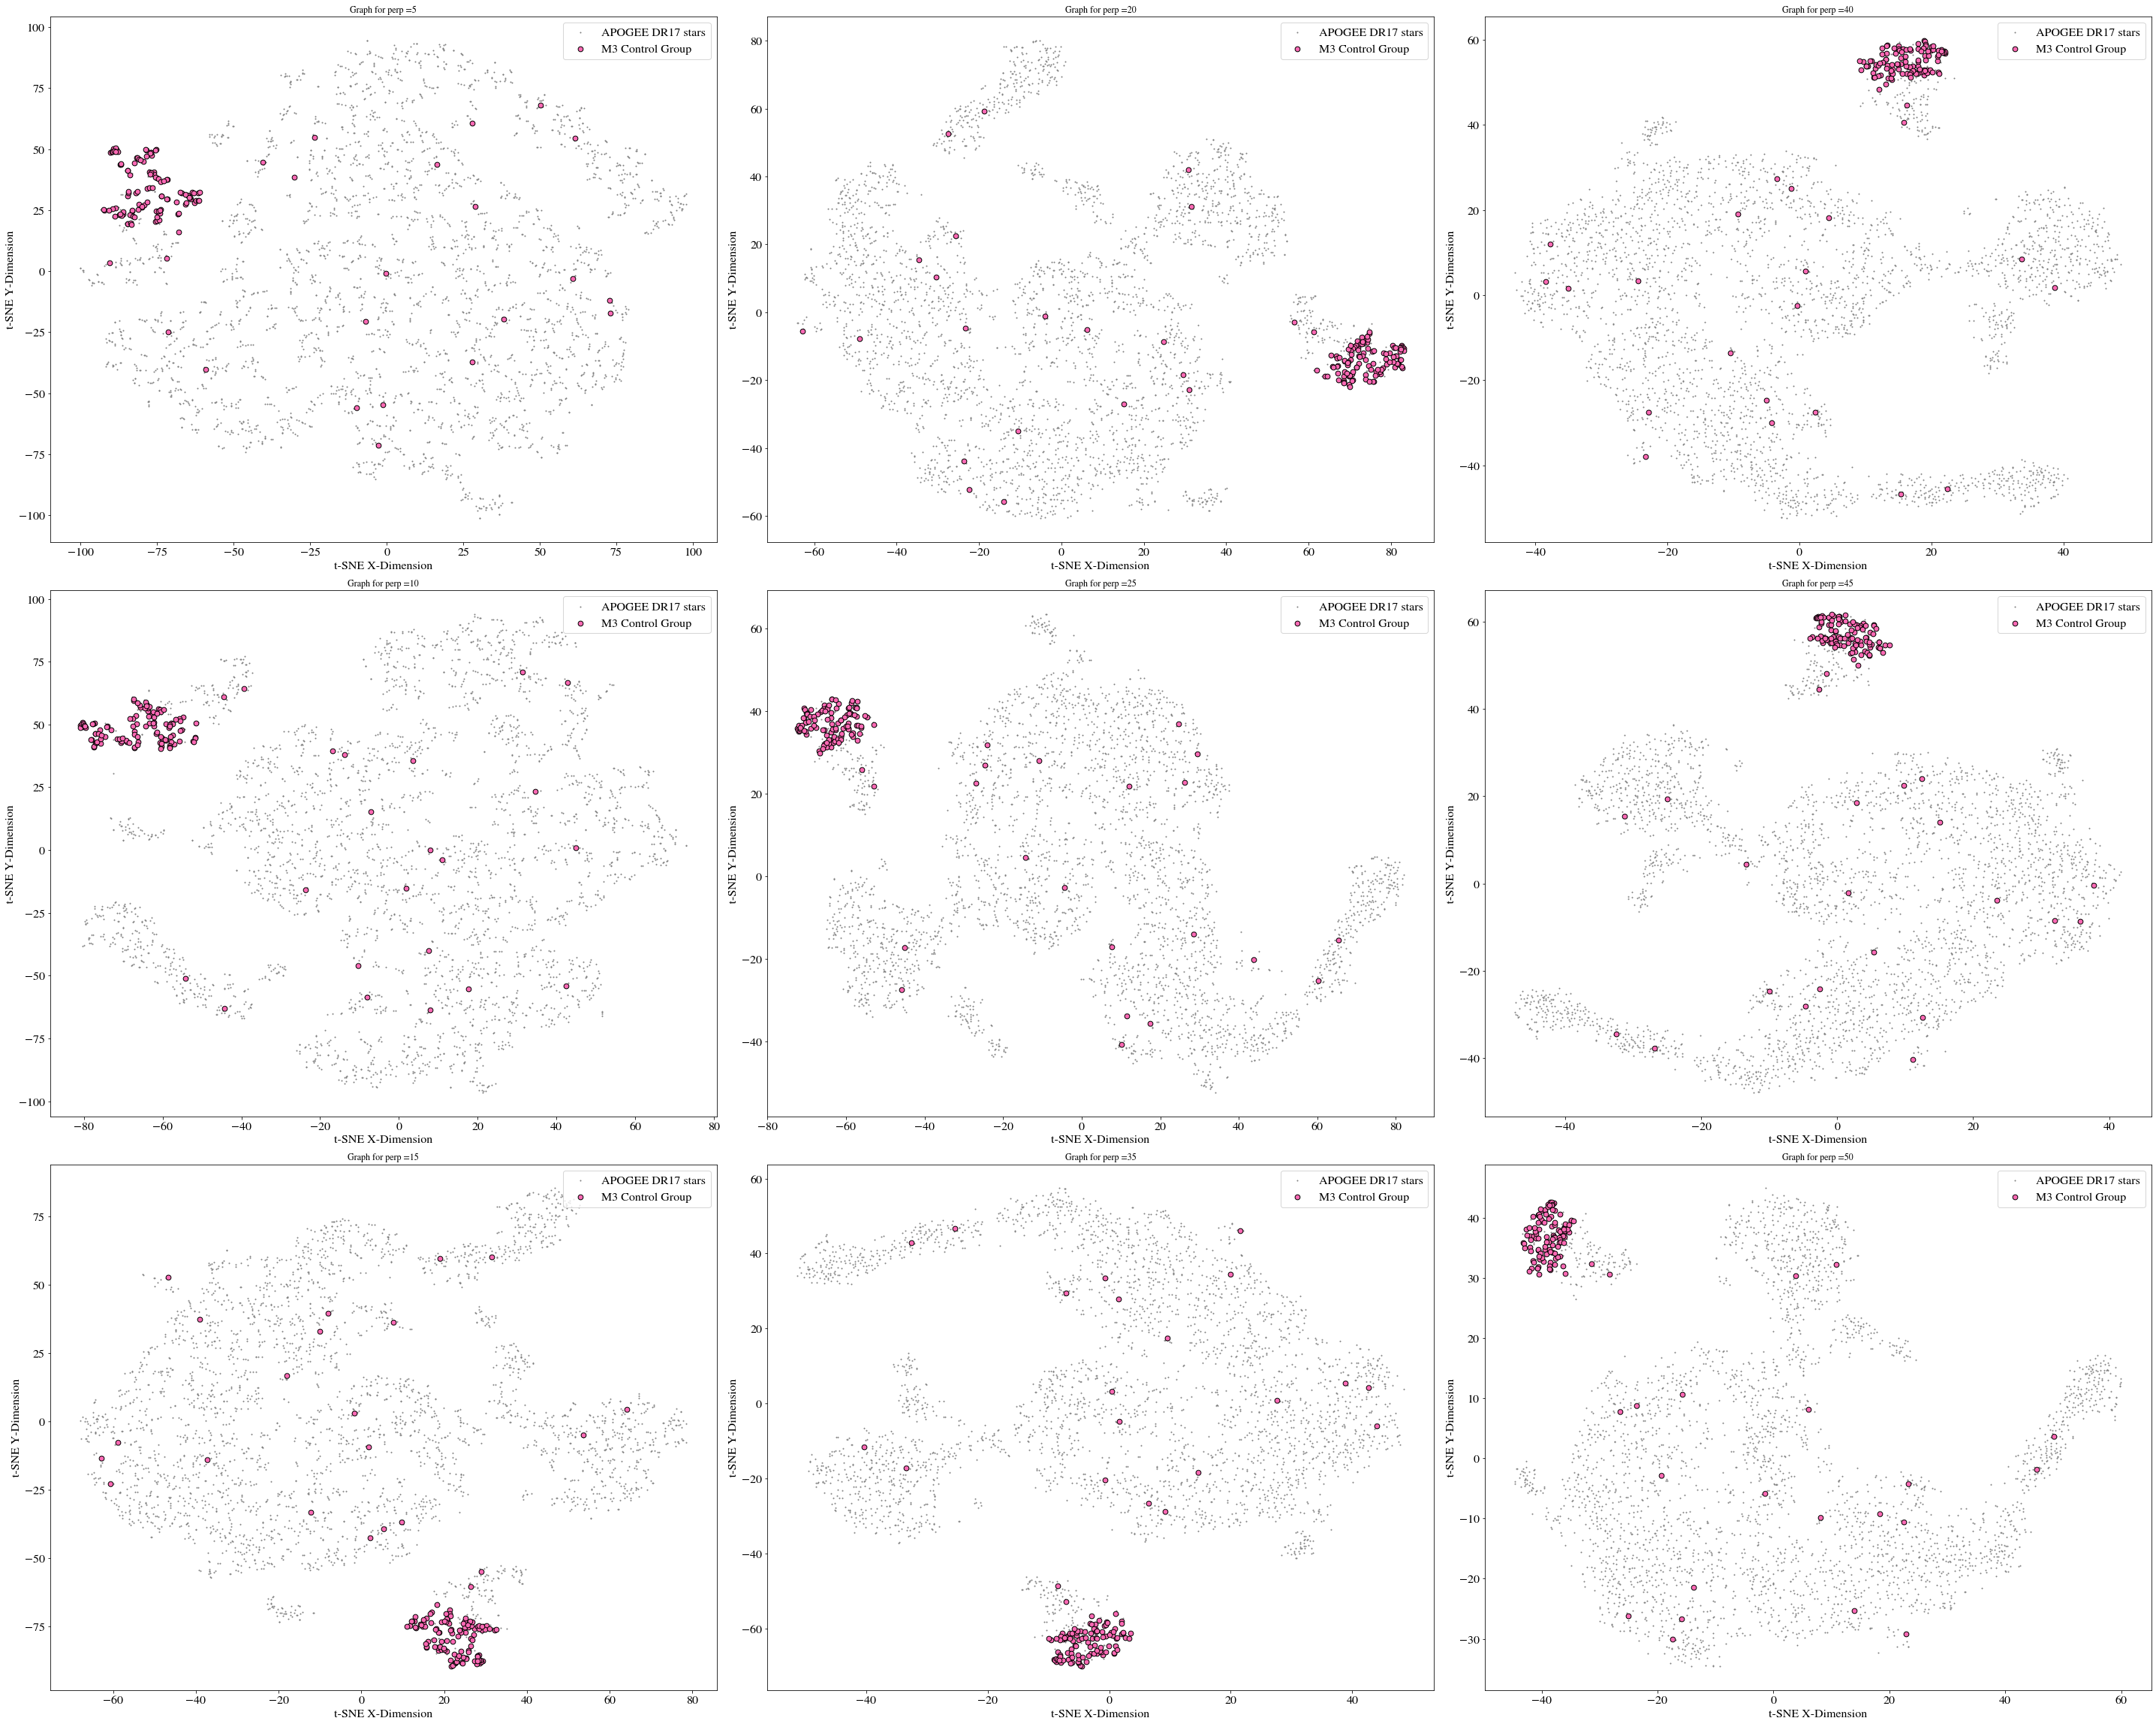

In [112]:
fig_perp, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_perp[i + 3 * j], t_SNE_dimY_perp[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_perp[i + 3 * j], tsne_dimY_control_perp[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for perp =' + str(perp_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_list[i + 3*j]), 'Control: ', len(tsne_dimX_control_list[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_perp')
plt.show()



Seems like the higher the perplexity, the more tightly grouped together the control stars. After 20 there seems to be a drop off in terms of cluster tightness increase. Running the same code doesn't yield the same graphs?

#### Changing early exaggeration (default 12)
controls tightness of natural clusters and how much space will be in between them?

In [106]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
exg_list = [4., 8., 16., 20., 24., 28., 32., 36., 40.]
t_SNE_dimX_exg = []
t_SNE_dimY_exg = []
tsne_dimX_control_exg = []
tsne_dimY_control_exg = []
for i in exg_list:
    tsne_init_exg = TSNE(n_components=2, perplexity=i)
    tsne_2d_exg = tsne_init_exg.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_exg.append(tsne_2d_exg[:, 0])
    t_SNE_dimY_exg.append(tsne_2d_exg[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_exg.append(t_SNE_dimX_exg[-1][indices_control])
    tsne_dimY_control_exg.append(t_SNE_dimY_exg[-1][indices_control])
    
    print('t_SNE done for exg =', i)

print('t_SNE done')

t_SNE done for exg = 4
t_SNE done for exg = 8
t_SNE done for exg = 16
t_SNE done for exg = 20
t_SNE done for exg = 24
t_SNE done for exg = 28
t_SNE done for exg = 32
t_SNE done for exg = 36
t_SNE done for exg = 40
t_SNE done


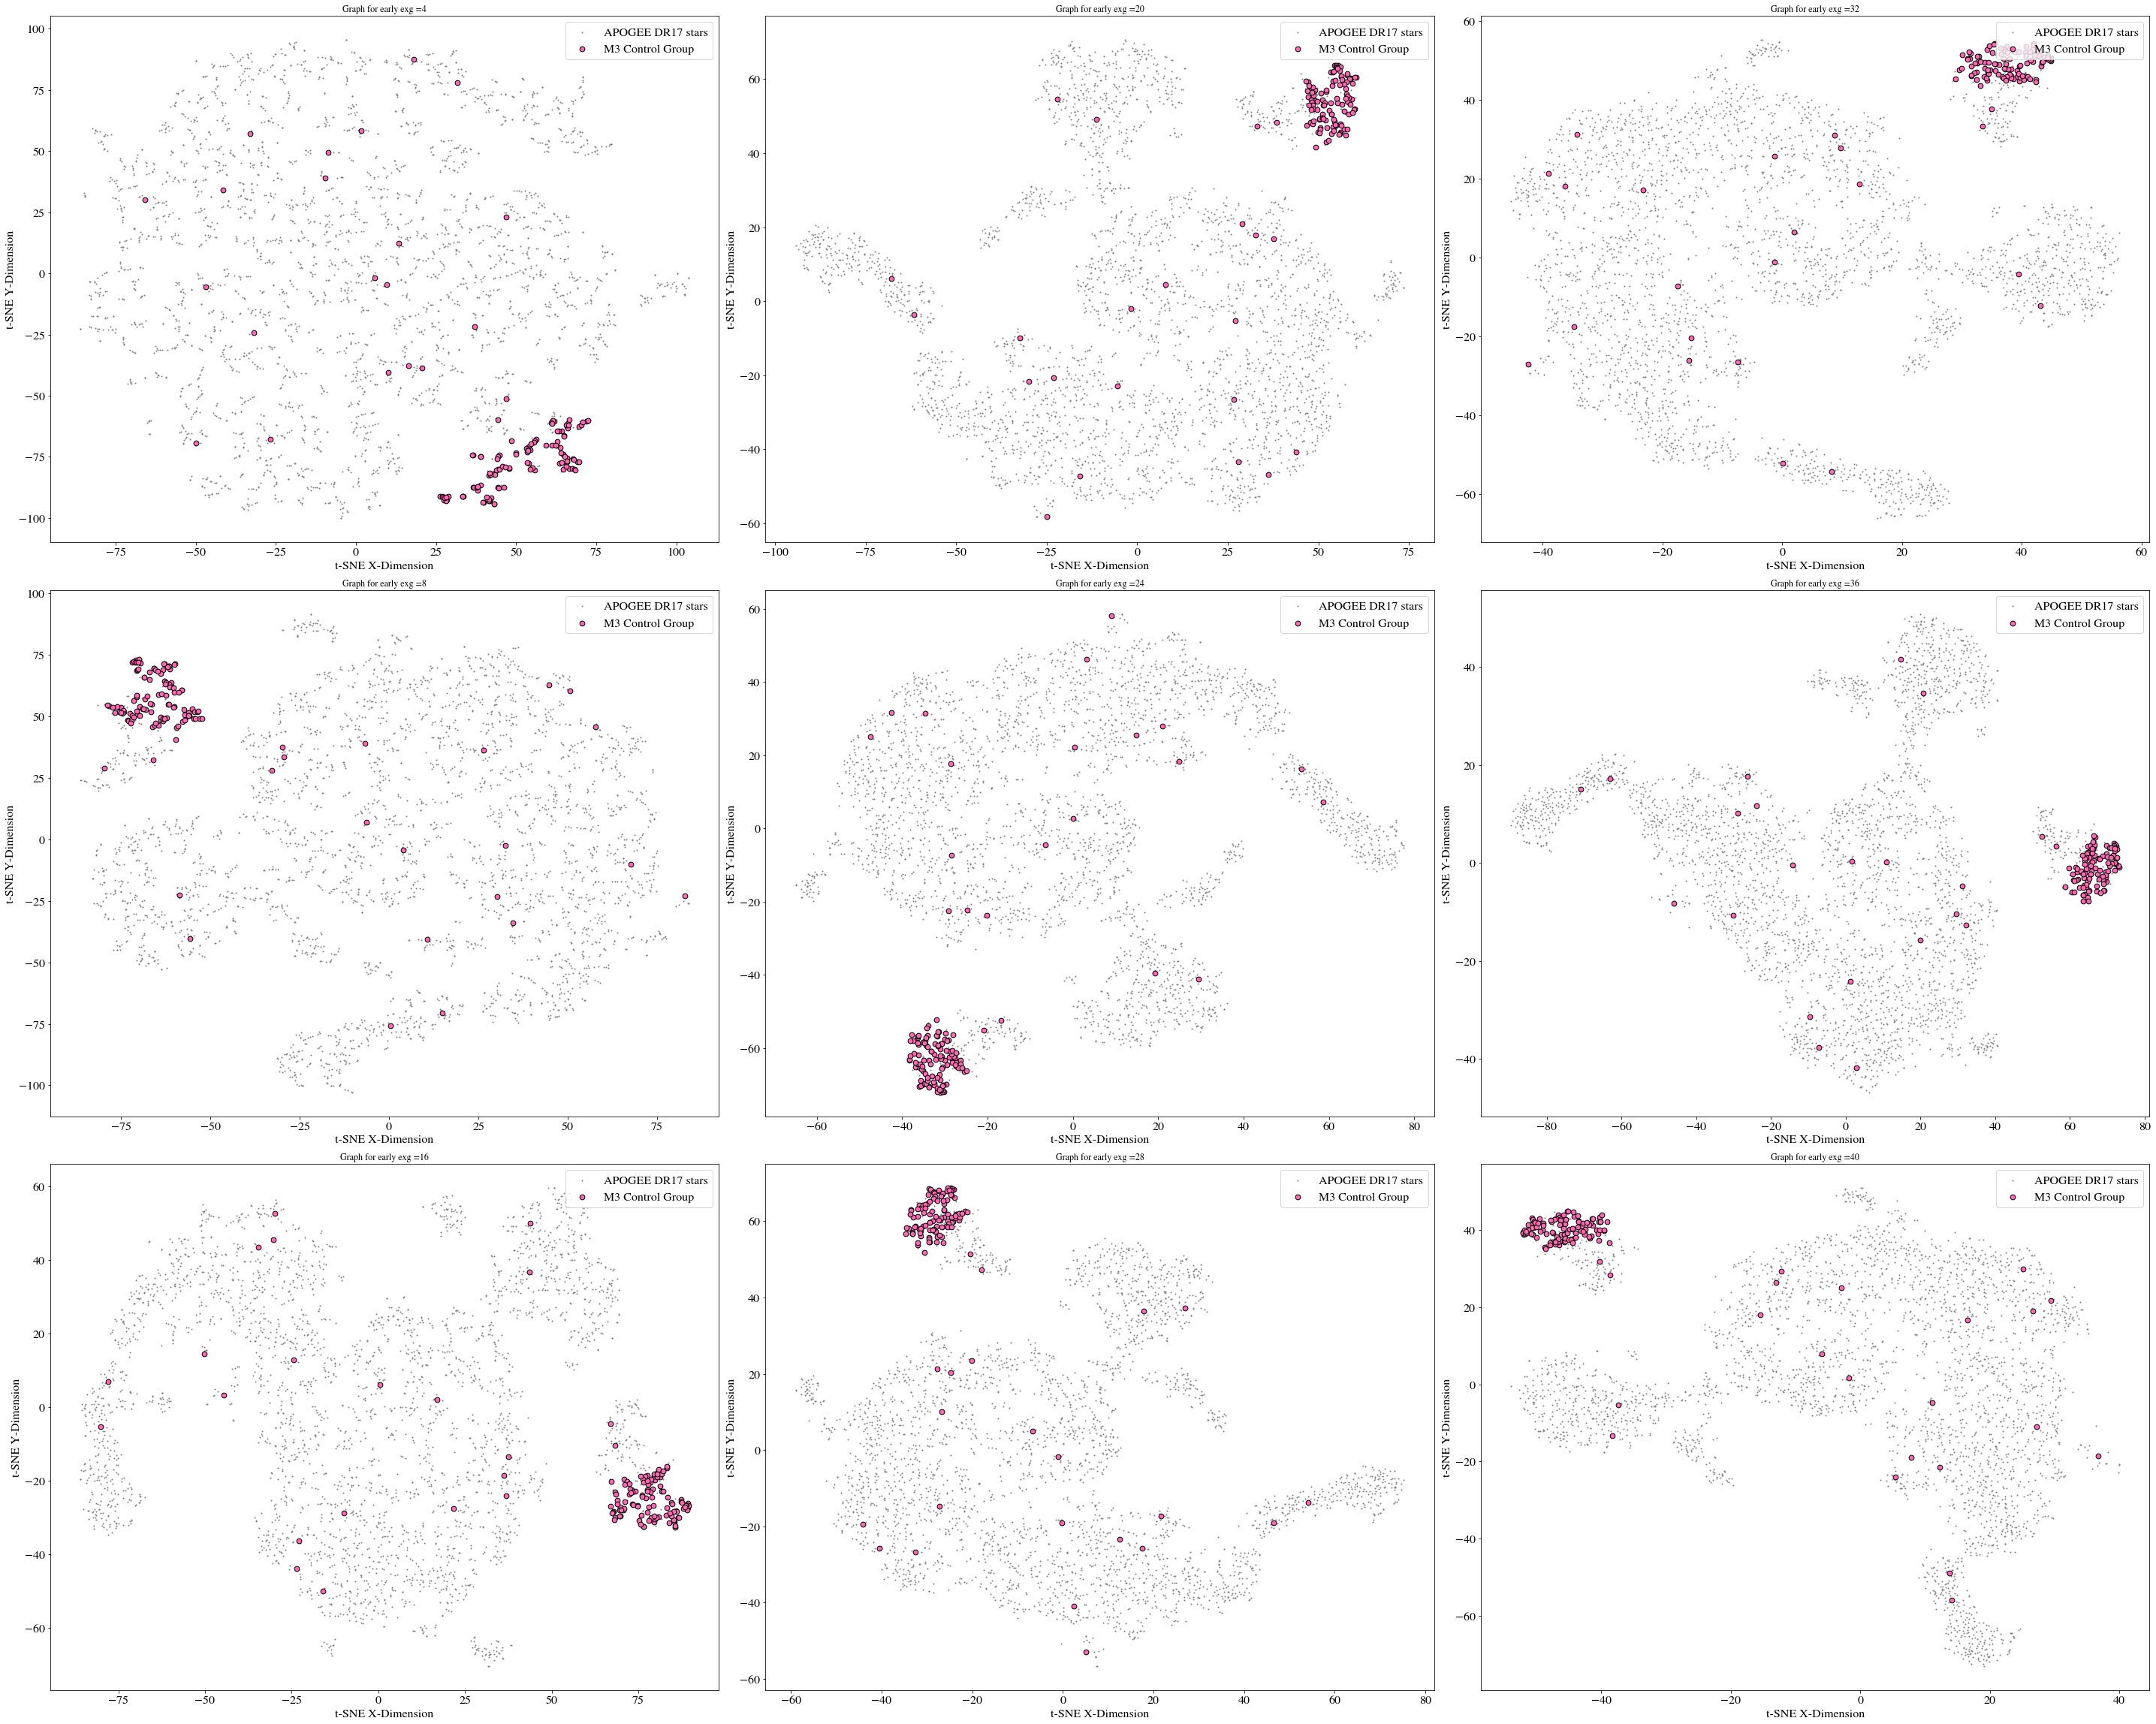

In [111]:
fig_exg, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_exg[i + 3 * j], t_SNE_dimY_exg[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_exg[i + 3 * j], tsne_dimY_control_exg[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for early exg =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_exg')
plt.show()



Seems like higher early exaggeration leads to tighter groups. Just like perplexity, there seems to be a falloff in group tightness increase

#### Changing learning rate (default 200)
something to do with step size and optimization for ML algorithms i think

In [108]:
### early exaggeration changing
# Transpose the standardized + filtered array:
standardized_array_transpose = np.transpose(standardized_array)

# Run t-SNE on the transposed array:
# early exaggeration list (default 12.)
learn_list = [10., 100., 300., 400., 500., 600., 700., 800., 900.]
t_SNE_dimX_learn = []
t_SNE_dimY_learn = []
tsne_dimX_control_learn = []
tsne_dimY_control_learn = []
for i in learn_list:
    tsne_init_learn = TSNE(n_components=2, learning_rate=i)
    tsne_2d_learn = tsne_init_learn.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    t_SNE_dimX_learn.append(tsne_2d_learn[:, 0])
    t_SNE_dimY_learn.append(tsne_2d_learn[:, 1])

    # Get t-SNE outputs for control group:
    tsne_dimX_control_learn.append(t_SNE_dimX_learn[-1][indices_control])
    tsne_dimY_control_learn.append(t_SNE_dimY_learn[-1][indices_control])
    
    print('t_SNE done for learn =', i)

print('t_SNE done')

t_SNE done for learn = 10.0
t_SNE done for learn = 100.0
t_SNE done for learn = 300.0
t_SNE done for learn = 400.0
t_SNE done for learn = 500.0
t_SNE done for learn = 600.0
t_SNE done for learn = 700.0
t_SNE done for learn = 800.0
t_SNE done for learn = 900.0
t_SNE done


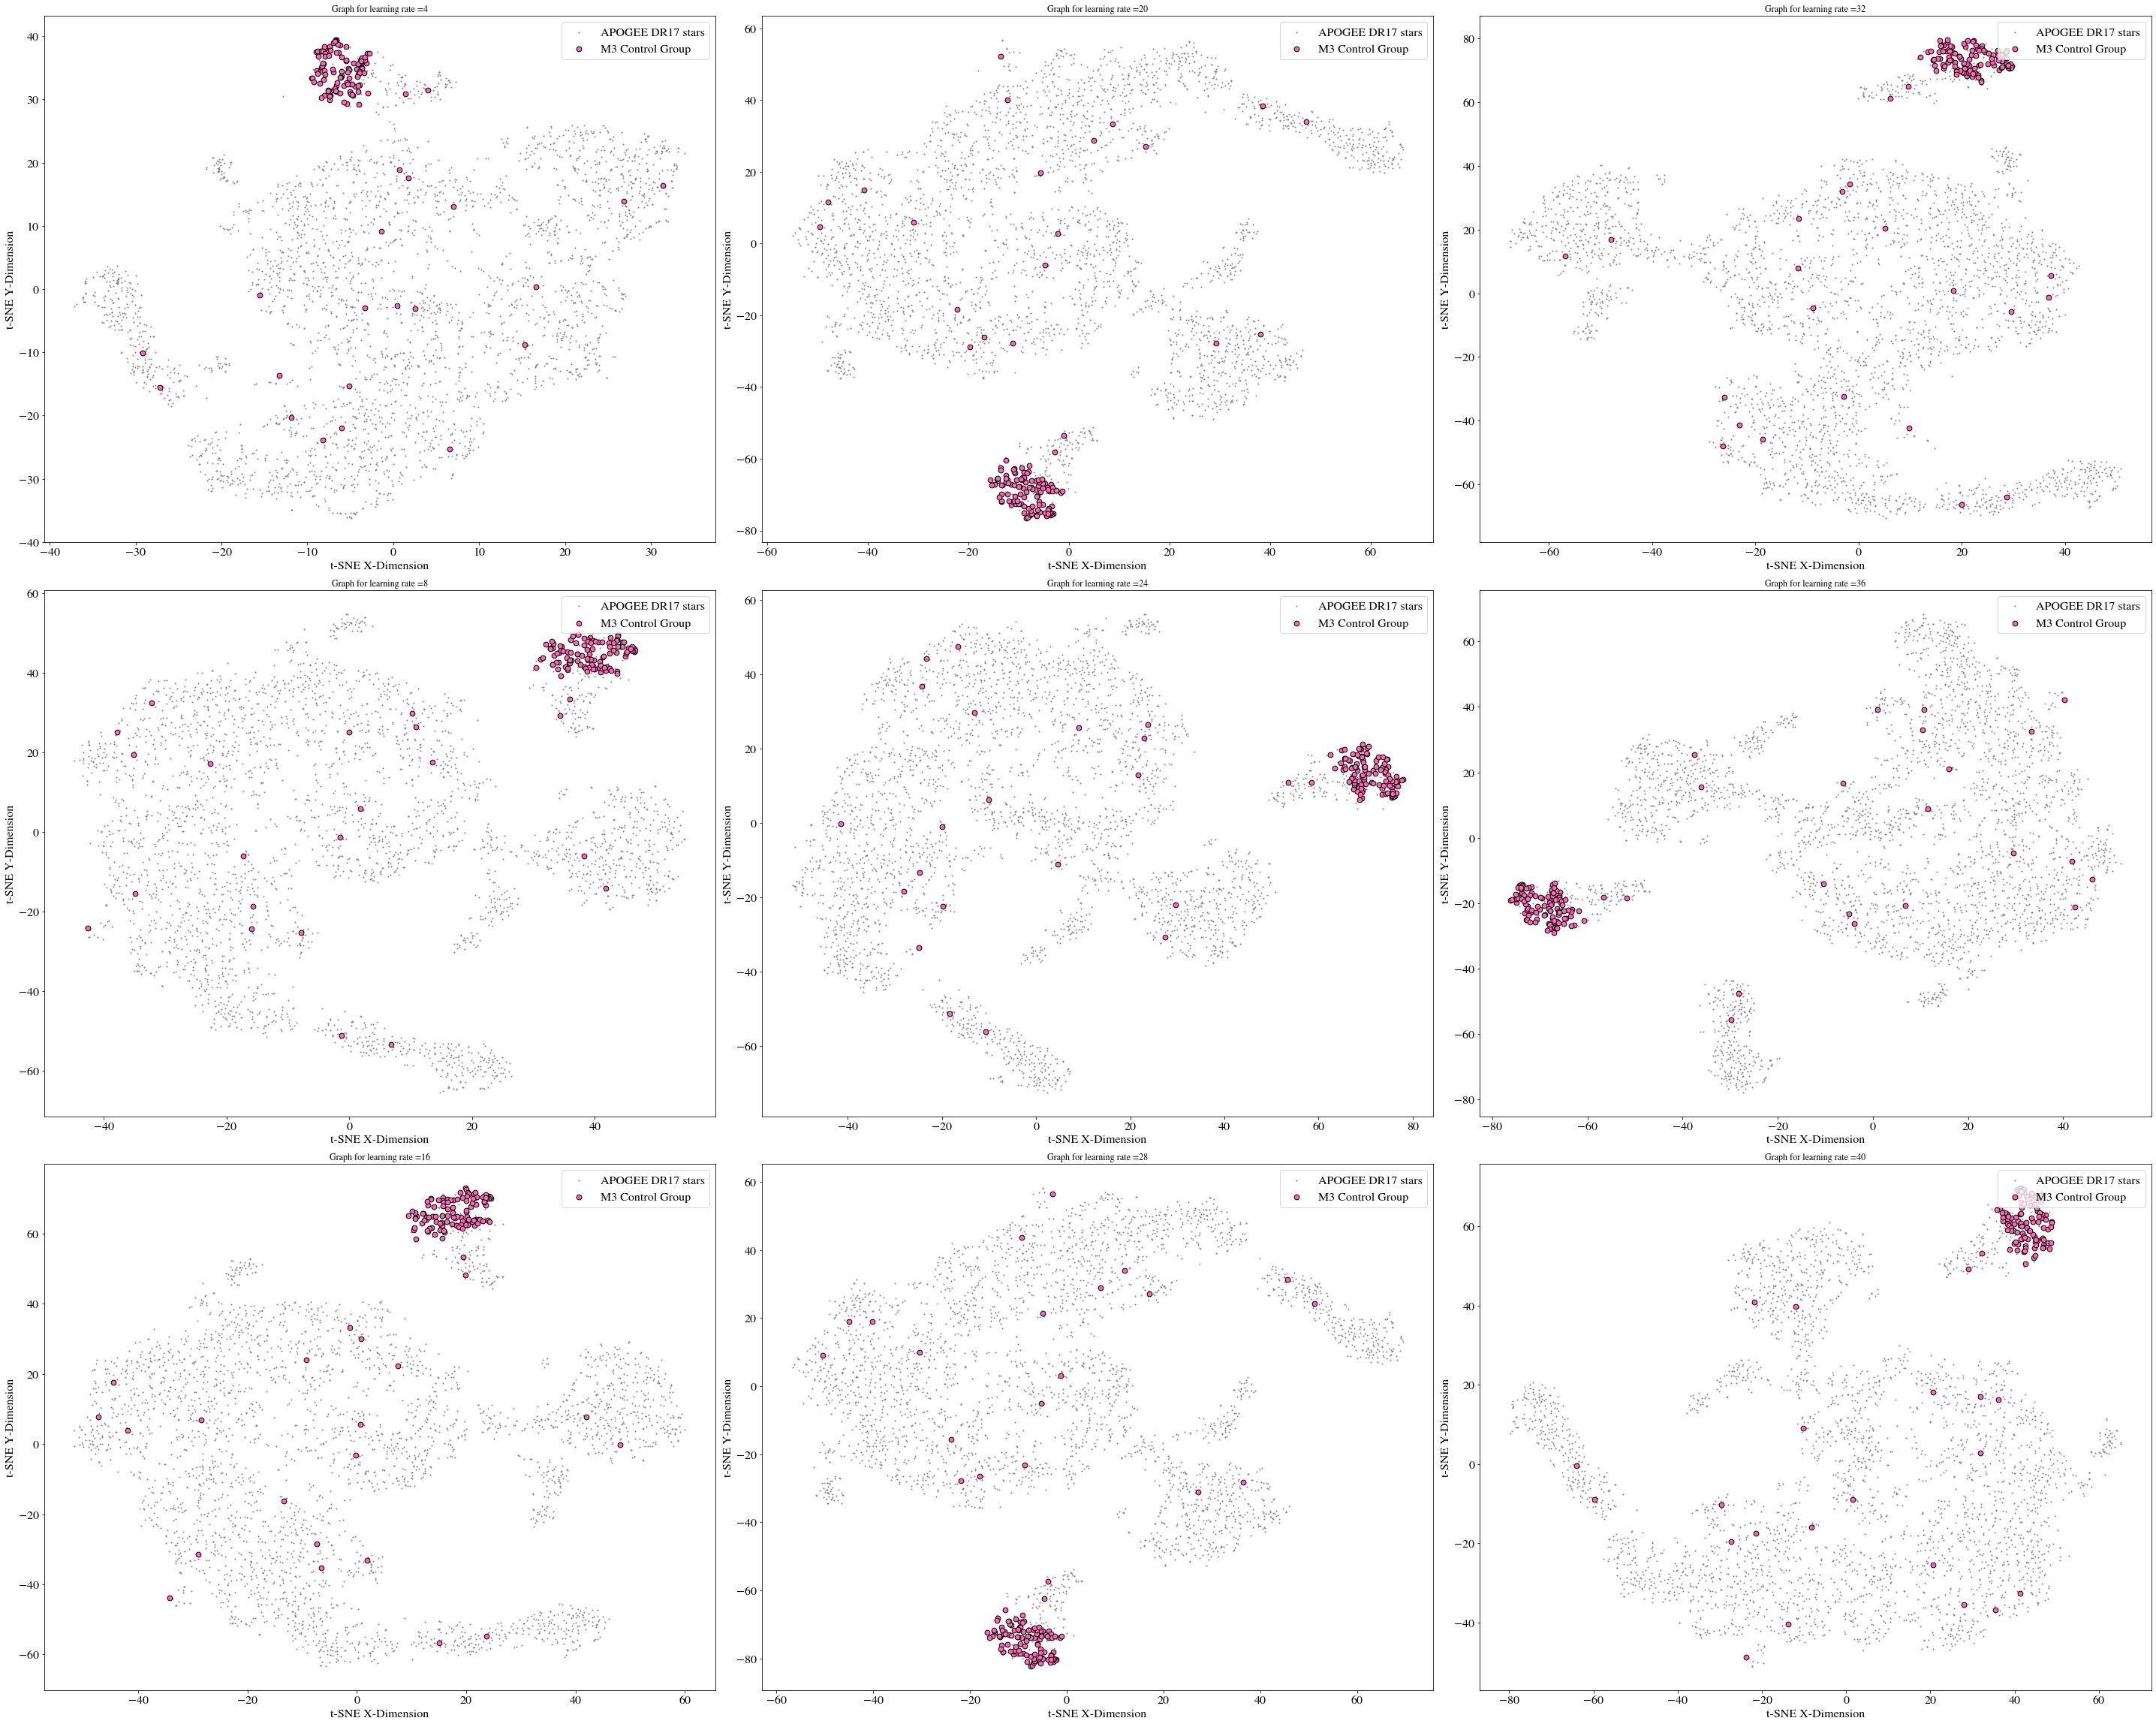

In [110]:
fig_learn, ax = plt.subplots(3, 3, figsize=(40,32))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(t_SNE_dimX_learn[i + 3 * j], t_SNE_dimY_learn[i + 3 * j], s=1, c='gray', label='APOGEE DR17 stars')
        ax[i,j].scatter(tsne_dimX_control_learn[i + 3 * j], tsne_dimY_control_learn[i + 3 * j], s=45, edgecolor='k', c='hotpink', label='M3 Control Group')
        ax[i,j].set_xlabel("t-SNE X-Dimension", fontsize=16)
        ax[i,j].set_ylabel("t-SNE Y-Dimension", fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=16)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=16)
        ax[i,j].set_title('Graph for learning rate =' + str(exg_list[i + 3 * j]))
        ax[i,j].legend(fontsize=16, loc=1)
        #print('Total: ', len(t_SNE_dimX_exg[i + 3*j]), 'Control: ', len(tsne_dimX_control_exg[i + 3 * j]))
plt.tight_layout()
plt.savefig('tSNE_learn')
plt.show()

Not too much noticable change surprisingly.

### OVerall remarks

Seems to have a similar structure each time, just different control group locations and orientations

#### ***CHECK-IN: You succesfully ran t-SNE!*

What does this specific t-SNE projection actually tell you? How could you improve this t-SNE run? Importantly, how could you extend this method to find extra-tidal candidates of M3?

This specific t-SNE only tells us the likely control group stars of M3 and where they fall in parameter space. A further analysis of the other stars that are similar to the M3 control group stars could identify extra tidal candidates.

#### Improving the Dimensionality Reduction
Fine tune the hyper-parameters:
- understand how the different hyper-parameters affect the data
- what combination of hyper-parameters achieve the best separation of the control group? to acheive the best 

Helpful Papers:

https://distill.pub/2016/misread-tsne/ 

https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868 

Dimensional Reduction Astronomy Example:
https://arxiv.org/pdf/2210.02471.pdf
